<h1> Modelos de MA(q) al modelar precios </h1>

En este reporte veremos como se comportan los modelos de medias móviles $MA(q)$ al modelar los precios.

<h2> Preprocesamiento de datos </h2>

In [2]:
import numpy as np # Para utilizar numpy
import pandas as pd # Para utilizar pandas
import matplotlib.pyplot as plt #Para las gráficas
import statsmodels.graphics.tsaplots as sgt #Gráficas de autocorrelación 
import statsmodels.tsa.stattools as sts #Para prueba de Dickey-Fuller
import seaborn as sns 
from statsmodels.tsa.arima.model import ARIMA #Para hacer el modelo ARIMA
from scipy.stats.distributions import chi2 #Nos sirve para la distribución Xi cuadrada 
from datetime import datetime #Para trabajar con fechas
import os #Para poner la dirección donde esta la base de datos.
sns.set()
os.chdir("C:\\Users\\81799\\OneDrive\\Documentos\\ESFM_CLASES\\Servicio Social ARTF\\Machine Learning\\curso-series-temporales-master\\5. Modelos AR autorregresivos\\Python") 
raw_csv_data = pd.read_csv("Index2018.csv") #Leer DataFrame Index2018
df_comp = raw_csv_data.copy() #Copia el DataFrame raw_csv_data con el nombre de df_comp
df_comp.date = pd.to_datetime(df_comp.date, dayfirst =True ) #Modifica las fechas
df_comp.set_index("date",inplace = True) # Ponemos las fechas como índices
df_comp=df_comp.asfreq("b") #Frecuencias a días laborales.
df_comp=df_comp.fillna(method="ffill")#Arregla problema d valores faltantes tomando su diferencia
df_comp["market_value"]=df_comp.ftse #Agregamos una nueva columna llamada market_value
del df_comp["spx"] #Eliminamos la columna spx del DataFrame de_comp
del df_comp["dax"] #Eliminamos la columna dax del DataFrame de_comp
del df_comp["ftse"] #Eliminamos la columna ftse del DataFrame de_comp
del df_comp["nikkei"] #Eliminamos la columna nikkei del DataFrame de_comp
size=int(len(df_comp)*0.8) #int (no. de filas*0.8)= int(6277*0.8)= int(5021.6)=5021
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

Recordemos que una manera de observar el nuúmero de coeficientes que necesitamos para el modelo $MA(q)$ es a través de la gráfica $ACF$. 

<h2> Gráfica $ACF$ </h2>

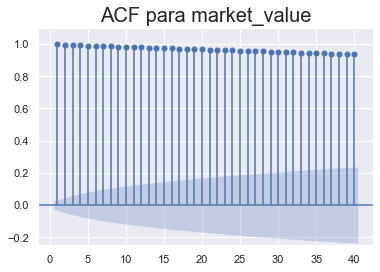

In [8]:
sgt.plot_acf(df.market_value, zero = False, lags = 40) 
plt.title("ACF para market_value", size = 20)
plt.ylim(-0.25,1.1)
plt.show() #Quitamos el primer NA para que nos de la gráfica

Analizando la gráfica obtenemos que los $40$ períodos son significativos, es decir, que se sugiere que se preferiría cualquier modelo de retraso superor a cualquier modelo de retraso inferior (Como cuando comparabamos los modelos ) lo que nos lleva a creer que tendríamos que usar un modelo infinito para ajustar estos datos. Pero como lo anterior, no existe, entonces parece que ningún modelo de promedio móvil sería una buena estimación de los precios.

Antes de esto, ajustemos un modelo $MA(1)$ para observar lo que pasa.


<h2> $MA(1)$ para market_value </h2>

In [9]:
model_ma_1 = ARIMA(df.market_value, order = (0,0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38629.000
Date:                Tue, 24 May 2022   AIC                          77264.000
Time:                        06:44:27   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6316     15.834    321.441      0.000    5058.598    5120.665
ma.L1          0.9573      0.004    231.410      0.000       0.949       0.965
sigma2      2.817e+05   8160.556     34.519      0.000    2.66e+05    2.98e+05
===================================================================================
Ljung-Box (L1) (Q):                4221.10   Jarque-Bera (JB):               291.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dado el modelo $MA(1)$, tenemos que:

* El $p-valor$ del coeficiente $c$ es igual a $0.000$, lo cual indica que $p-valor _c <0.05$, por lo cual rechazamos $H_0$, así que **el coeficiente de $c$ es significativamente distinto de $0$**.

* El $p-valor$ del coeficiente $\theta _1$ es igual a $0.000$, lo cual indica que $p-valor _c <0.05$, por lo cual rechazamos $H_0$, así que **el coeficiente de $\theta _1$ es significativamente distinto de $0$**.

* El parametro de $\theta _1=0.9573\approx 1$, lo que significa que el modelo $MA(1)$ está intentando mantener casi toda la magnitud del término error del último período $\varepsilon _{t-1}$.

Con lo anterior, observamos que:
$$\begin{array}{l}  x_{t-1}&=c+\theta _1\varepsilon _{t-2}+\varepsilon _{t-1} \ldots (1) \\ x_{t}&=c+\theta _1\varepsilon _{t-1}+\varepsilon _t \;\;\; \ldots (2) \end{array} $$
Sustituyendo $\varepsilon _{t-1}$ de la ec($2$) en la ec($1$), obtenemos lo siguiente:
$$\begin{array}{l}  x_{t}=c+\theta _1 (x_{t-1}-c+\theta _1\varepsilon _{t-2})+\varepsilon _t  \ldots (3)\end{array}$$
Pero como $\theta _1 \approx 1$, entonces tenemos que: 
$$x_t=x_{t-1}+\epsilon _{t-2}+\epsilon _t$$

**Concluimos:** Los modelos de medias móviles NO funcionan bien para datos NO estacionarios.